# STEP 0

## 0.1. Imports


In [37]:
import warnings
import pandas                   as pd
import numpy                    as np
import sweetviz                 as sv
import seaborn                  as sns
import matplotlib.pyplot        as plt
from sklearn.decomposition      import PCA
from sklearn.cluster            import KMeans
from sklearn.preprocessing      import StandardScaler
from sklearn.preprocessing      import OrdinalEncoder
from yellowbrick.cluster        import KElbowVisualizer
from sklearn.metrics            import silhouette_score

## 0.2. Helper Functions

In [38]:
# ===================================================================
# Configura os gráficos
def jupyter_settings():
    warnings.filterwarnings('ignore')
    
    %matplotlib inline
    # %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [22, 9]
    plt.rcParams['font.size'] = 21

    # display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    # configura o pandas para quantidade de casas decimais
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    sns.set()

jupyter_settings()

## 0.3. Loading Data

In [39]:
df_raw = pd.read_csv('../dados/spotify.csv', low_memory=False)

In [40]:
df_raw.drop_duplicates(subset='id', inplace=True)

# 1 - Data understanding


In [41]:
df2 = df_raw.copy().reset_index(drop=True)
df2.head(2)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,Unnamed: 0,title,artist_name,track_name,album_name
0,0.82,0.76,8,-5.39,1,0.10,0.01,0.00,0.33,0.16,149.97,audio_features,5o7ZDvfOry1MNhNLBOJulo,spotify:track:5o7ZDvfOry1MNhNLBOJulo,https://api.spotify.com/v1/tracks/5o7ZDvfOry1M...,https://api.spotify.com/v1/audio-analysis/5o7Z...,163371,4,Dark Trap,1000 Rounds,NaN,NaN,Pouya,1000 Rounds,1000 Rounds
1,0.77,0.58,10,-9.68,0,0.26,0.14,0.00,0.10,0.19,139.99,audio_features,1umsRbM7L4ju7rn9aU8Ju6,spotify:track:1umsRbM7L4ju7rn9aU8Ju6,https://api.spotify.com/v1/tracks/1umsRbM7L4ju...,https://api.spotify.com/v1/audio-analysis/1ums...,96062,4,Dark Trap,Sacrifice,NaN,NaN,The Expendables,Sacrifice,Gettin' Filthy


## 1.1. Rename Columns

In [42]:
df2.columns = [
    "dancabilidade","energia","nota","volume","tonalidade","letra","acustica","instrumental","ao_vivo",
    "alegre","ritmo","tipo","id","uri","track_href","analysis_url","duracao_ms","compasso","genero",
    "nome","desconhecido","compl_genero","artista","musica","album"
]


## 1.2. Data Dimensions

In [43]:
# Conferindo a volumetria
print(f"Quantidade de linhas:   {df2.shape[0]}")
print(f"Quantidade de colunas:  {df2.shape[1]}")
print(f"IDs únicos:             {df2.id.nunique()}\n")

Quantidade de linhas:   6508
Quantidade de colunas:  25
IDs únicos:             6508



## 1.3. Data Types

In [44]:
df2.dtypes

dancabilidade    float64
energia          float64
nota               int64
volume           float64
tonalidade         int64
letra            float64
acustica         float64
instrumental     float64
ao_vivo          float64
alegre           float64
ritmo            float64
tipo              object
id                object
uri               object
track_href        object
analysis_url      object
duracao_ms         int64
compasso           int64
genero            object
nome              object
desconhecido     float64
compl_genero     float64
artista           object
musica            object
album             object
dtype: object

## 1.4. Change Data Types

In [45]:
'''
Alterando os tipos de int64 e float64 para int32 e float32 respectivamente com o 
intuito de melhorar a performance
'''

# Reduzindo tamanho para performance
for col in df2.select_dtypes(include=["int64"]):
    df2[col] = df2[col].astype('int32')
for col in df2.select_dtypes(include=["float64"]):
    df2[col] = df2[col].astype('float32')


genero = {"Dark Trap":1, "dnb":2, "Emo":3, "Hiphop":4, "hardstyle":5, "Pop":6, "psytrance":7,
    "Rap":8, "RnB":9, "techhouse":10, "techno":11, "trance":12, "trap":13, "Trap Metal":14, "Underground Rap":15,}
df2.genero = df2.genero.map(genero)

## 1.5. Check NA


In [46]:
df2.isnull().mean()

dancabilidade   0.00
energia         0.00
nota            0.00
volume          0.00
tonalidade      0.00
letra           0.00
acustica        0.00
instrumental    0.00
ao_vivo         0.00
alegre          0.00
ritmo           0.00
tipo            0.00
id              0.00
uri             0.00
track_href      0.00
analysis_url    0.00
duracao_ms      0.00
compasso        0.00
genero          0.00
nome            0.00
desconhecido    1.00
compl_genero    1.00
artista         0.00
musica          0.00
album           0.00
dtype: float64

## 1.6. Descriptive Statistical


In [47]:
# Separando os atributos entre numéricos e categóricos
numerical_attributes = df2.select_dtypes(include=['int32', 'float32'])
categorical_attributes = df2.select_dtypes(exclude=['int32', 'float32'])

### 1.6.1 Numerical Features

In [48]:
numerical_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
dancabilidade,6508.00,0.64,0.16,0.10,0.53,0.66,0.77,0.99
energia,6508.00,0.67,0.18,0.02,0.54,0.68,0.81,1.00
nota,6508.00,5.21,3.62,0.00,1.00,5.00,8.00,11.00
volume,6508.00,-6.79,2.84,-24.56,-8.32,-6.37,-4.75,3.15
tonalidade,6508.00,0.56,0.50,0.00,0.00,1.00,1.00,1.00
letra,6508.00,0.16,0.13,0.02,0.05,0.10,0.25,0.95
acustica,6508.00,0.17,0.22,0.00,0.01,0.07,0.25,0.98
instrumental,6508.00,0.07,0.21,0.00,0.00,0.00,0.00,0.98
ao_vivo,6508.00,0.19,0.15,0.02,0.10,0.13,0.25,0.97
alegre,6508.00,0.44,0.23,0.03,0.25,0.44,0.62,0.97


### 1.6.2 Categorical Features

In [49]:
display( pd.DataFrame( categorical_attributes.apply(lambda x: x.unique().shape[0]), columns=[ 'Valores únicos'], ).sort_values('Valores únicos'))

,Valores únicos
tipo,1
genero,8
artista,1957
album,3061
nome,4499
musica,4499
id,6508
uri,6508
track_href,6508
analysis_url,6508


In [50]:
df2.genero.value_counts()

15    1305
1     1161
4     1111
3     1090
9      994
8      424
6      280
14     143
Name: genero, dtype: int64

### 1.7 Target Feature

In [51]:
# TODO

# 2 - Exploratory data analisys

In [52]:
my_report = sv.analyze(df2)
my_report.show_html()

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## 2.1. Análise Multivariada

In [55]:
corr = numerical_attributes.corr().round(1)
corr

,dancabilidade,energia,nota,volume,tonalidade,letra,acustica,instrumental,ao_vivo,alegre,ritmo,duracao_ms,compasso,desconhecido,compl_genero
dancabilidade,1.00,-0.20,0.00,-0.10,-0.00,0.20,-0.00,-0.20,-0.10,0.30,-0.10,-0.10,0.10,NaN,NaN
energia,-0.20,1.00,0.00,0.70,0.00,-0.00,-0.50,-0.00,0.20,0.30,0.00,0.00,0.10,NaN,NaN
nota,0.00,0.00,1.00,0.00,-0.20,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,NaN,NaN
volume,-0.10,0.70,0.00,1.00,0.10,-0.10,-0.30,-0.20,0.10,0.30,0.00,0.10,0.00,NaN,NaN
tonalidade,-0.00,0.00,-0.20,0.10,1.00,-0.00,-0.00,-0.10,0.00,0.00,-0.00,-0.00,-0.00,NaN,NaN
letra,0.20,-0.00,0.00,-0.10,-0.00,1.00,0.00,-0.20,0.10,0.20,0.10,-0.00,0.00,NaN,NaN
acustica,-0.00,-0.50,-0.00,-0.30,-0.00,0.00,1.00,-0.00,-0.10,-0.10,-0.00,-0.00,-0.10,NaN,NaN
instrumental,-0.20,-0.00,0.00,-0.20,-0.10,-0.20,-0.00,1.00,-0.00,-0.30,-0.10,0.00,0.00,NaN,NaN
ao_vivo,-0.10,0.20,0.00,0.10,0.00,0.10,-0.10,-0.00,1.00,0.10,0.00,0.10,-0.00,NaN,NaN
alegre,0.30,0.30,0.00,0.30,0.00,0.20,-0.10,-0.30,0.10,1.00,0.10,-0.00,0.00,NaN,NaN


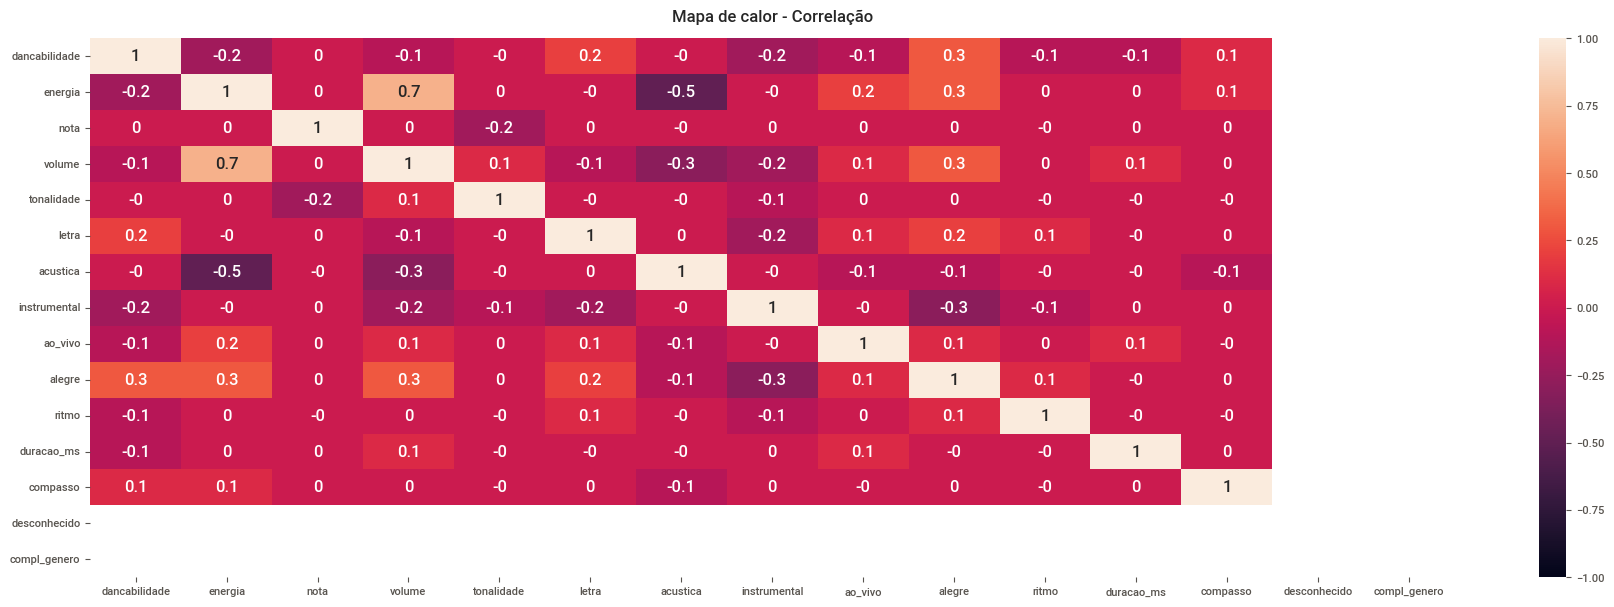

In [56]:
plt.figure(figsize=(22, 7))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
heatmap.set_title("Mapa de calor - Correlação", fontdict={"fontsize": 12}, pad=12);

# 3 - Feature selection

## 3.1. Filtragem de linhas

In [57]:
df3 = df2.copy()

## 3.2. Filtragem de colunas

In [59]:
# Excluindo colunas com dados faltantes acima de 90% e
# as colunas sem variância nos dados
df3.drop(columns=['desconhecido', 'tipo', 'compl_genero'], inplace=True)

# 4 - Data preparation

In [61]:
# Excluindo colunas de identificação
df_final = df3.drop(columns=["id", "uri", "track_href", "analysis_url", "nome", 'artista', 'musica', 'album'])

# processamento das variáveis categóricas
enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
df_final[["genero"]] = enc.fit_transform(df_final[["genero"]])

# processamento das variáveis numéricas
scaler = StandardScaler()
df_final[
    [
        "dancabilidade","energia","nota","volume","tonalidade","letra","acustica","instrumental","ao_vivo","alegre","ritmo","duracao_ms","compasso",
    ]
] = scaler.fit_transform(
    df_final[
        [
            "dancabilidade","energia","nota","volume","tonalidade","letra","acustica","instrumental","ao_vivo","alegre","ritmo","duracao_ms","compasso",
        ]
    ]
)

## PCA

In [62]:
pca = PCA(2)

# Usando PCA para reduzir dimensionalidade do dataset
df_final2 = pca.fit_transform(df_final)

# 5 - Modeling

## WSS Score

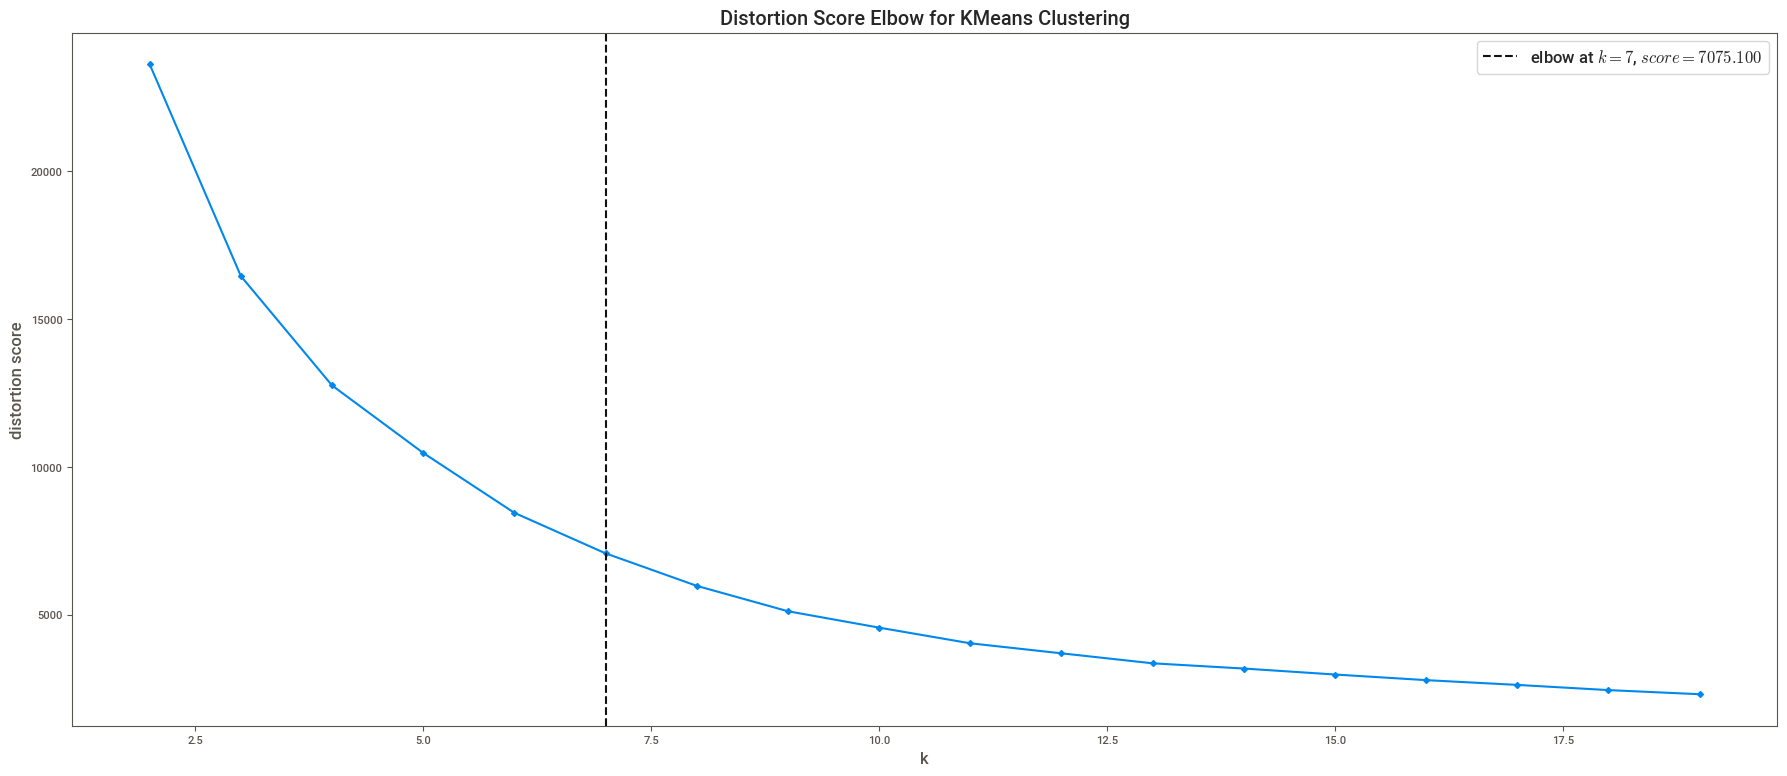

In [63]:
range_clusters = list(range(2,20))

kmeans = KElbowVisualizer( 
    KMeans(
        init="k-means++", 
        max_iter=500, 
        n_init=10, 
        random_state=42        
    ), k=range_clusters, timings=False )
kmeans.fit(df_final2)
kmeans.show();

## K-Means

In [64]:
def executa_kmeans(clusters, plot):
    result = KMeans(
        n_clusters=clusters,
        init="k-means++", 
        max_iter=1000, 
        n_init=10, 
        random_state=42
        )

    result.fit(df_final2)

    label = result.labels_
    df3['kmeans_cluster'] = label

    df3.kmeans_cluster.value_counts()

    # Pegando os clusters unicos
    u_labels = np.unique(label)
    
    # Plotando os resultados
    if plot:
        for i in u_labels:
            plt.scatter(df_final2[label == i , 0] , df_final2[label == i , 1] , label = i)
        plt.legend()
        plt.show()

    # Métrica de silhueta
    silhouette_avg = silhouette_score(df_final2, label)
    print(f'{clusters} clusters  -> Sillhouette score = {silhouette_avg}')

## Compararing

In [65]:
# Comparando silhouette_score e o gráfico de 5 à 15 clusters
for i in range(5, 15):
    executa_kmeans(i, False)

5 clusters  -> Sillhouette score = 0.4105957686958767
6 clusters  -> Sillhouette score = 0.42310713464811717
7 clusters  -> Sillhouette score = 0.42361590300536484
8 clusters  -> Sillhouette score = 0.42517459024810866
9 clusters  -> Sillhouette score = 0.43162847845267505
10 clusters  -> Sillhouette score = 0.43214607662156074
11 clusters  -> Sillhouette score = 0.43004188249241565
12 clusters  -> Sillhouette score = 0.4243254247837118
13 clusters  -> Sillhouette score = 0.42011189864645376
14 clusters  -> Sillhouette score = 0.39580561892916954


## Modelo final

In [66]:
result = KMeans(
    n_clusters=9,
    init="k-means++", 
    max_iter=1000, 
    n_init=9, 
    random_state=42
    )

result.fit(df_final2)

label = result.labels_
df3['kmeans_cluster'] = label

df3.kmeans_cluster.value_counts()

4    1006
0     955
2     885
1     863
5     747
3     617
7     539
6     523
8     373
Name: kmeans_cluster, dtype: int64

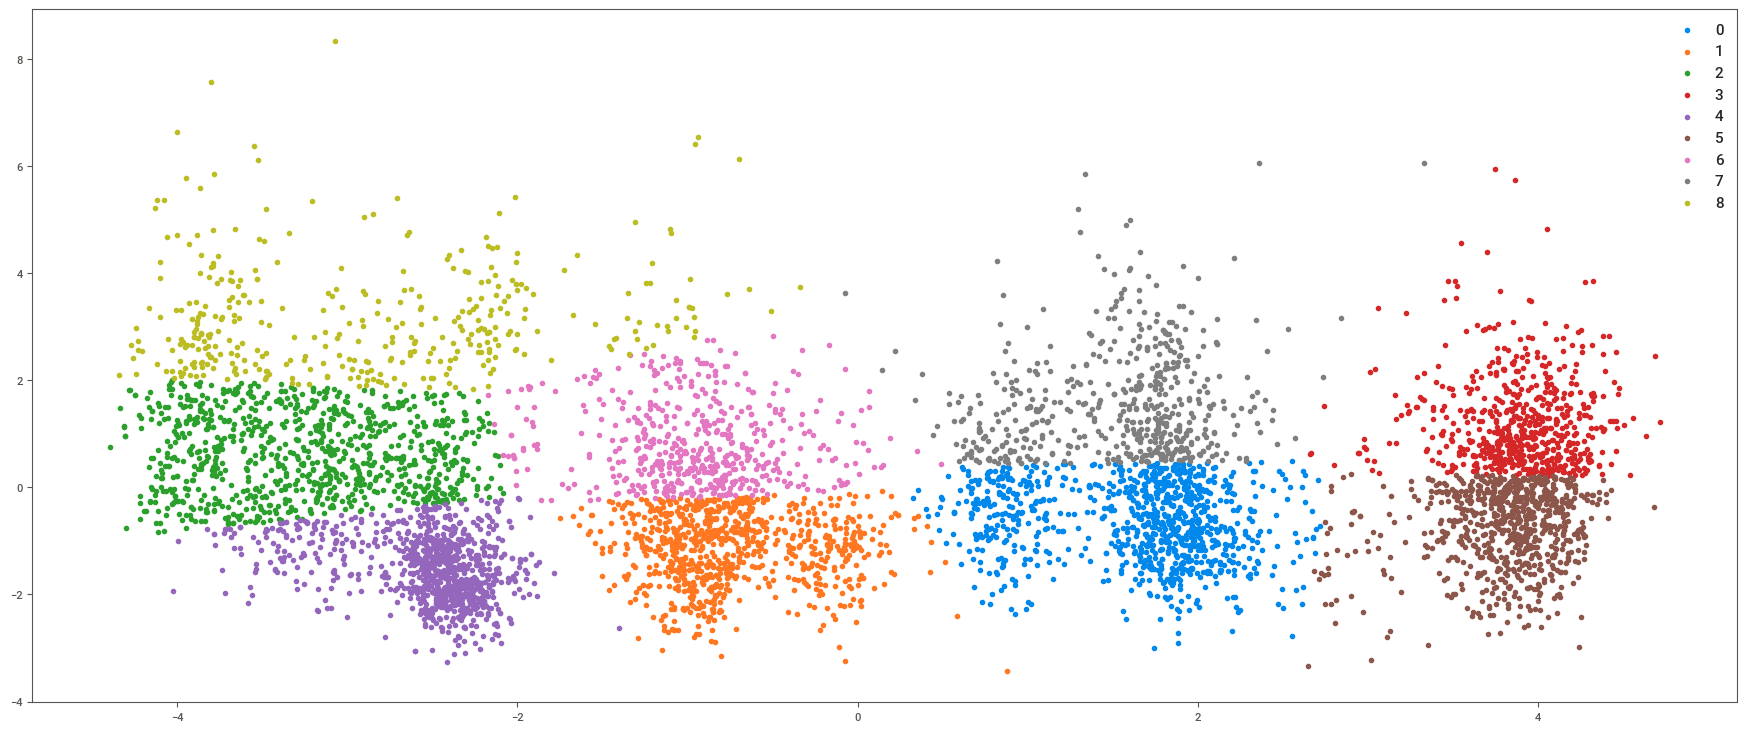

Sillhouette score = 0.43162847845267505


In [67]:
# Pegando os clusters unicos
u_labels = np.unique(label)

# Plotando os resultados
for i in u_labels:
    plt.scatter(df_final2[label == i , 0] , df_final2[label == i , 1] , label = i)
plt.legend()
plt.show()

# Métrica de silhueta
silhouette_avg = silhouette_score(df_final2, label)
print(f'Sillhouette score = {silhouette_avg}')

## Save dataset

In [68]:
df4 = df3[['artista', 'musica', 'album', 'kmeans_cluster']].copy()
df4.to_csv('lista_musicas.csv', index=False)
df4.sample(10)

,artista,musica,album,kmeans_cluster
1516,Sander van Doorn,Need To Feel Loved,Need To Feel Loved,2
5839,M.O.P.,Ante Up (Robbin Hoodz Theory),"B2K Presents ""You Got Served"" Soundtrack",1
566,Papa Roach,Forever,The Paramour Sessions,8
6238,2Pac,Run Tha Streetz,All Eyez On Me,1
5681,Drake,One Dance,Views,1
6438,M.O.P.,Hustle,Street Certified,1
2862,f(x),All Mine,All Mine,3
3069,Das EFX,They Want EFX,Dead Serious,3
2015,Passenger,Let Her Go,All The Little Lights,8
1821,Fabolous,My Time,Loso's Way,5


## New data

In [69]:
colunas = [
    "dancabilidade","energia","nota","volume","tonalidade","letra","acustica",
    "instrumental","ao_vivo","alegre","ritmo","duracao_ms","compasso","genero",
]
valores = [
    [
        0.148,-1.01,0.62,0.85,-0.27,1.021,-0.22,
        -0.39,1.24,0.61,1.44,1.6,1.15,0.00,
    ],
    [
        -0.48,1.1,-0.26,-0.58,0.72,-1.1,0.22,
        0.93,-1.42,-0.61,1.44,1.6,1.15,0.00,
    ],
]

dados_novos = pd.DataFrame(valores, columns=colunas)
cluster = result.predict(pca.fit_transform(dados_novos))

print(f'Música 1 pertence ao cluster: {cluster[0]}\nMúsica 2 pertence ao cluster: {cluster[1]}')

Música 1 pertence ao cluster: 0
Música 2 pertence ao cluster: 2
